# Quick Start Tutorial

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomaly detection.

* 基于MXNet
* 包含了预测模型，也支持其他类型的时序预测问题，比如分类、异常检测

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:

* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* 构建新模型（likehoods,特征抽取pipeline,日期特征等）
* Data loading and processing
* 数据加载和处理
* A number of pre-built models
* 一些pre-built模型
* Plotting and evaluation facilities
* 绘图和评估
* Artificial and real datasets (only external datasets with blessed license)
* 数据集



In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## 1.数据理解（Datasets）

### GluonTS datasets

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

* 这儿是自带的一些数据集

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

* 利用get_dataset函数访问上述数据集
* 参数 regenerate=False 可以避免数据集重新下载

* 下载下来的数据保存在用户个人目录下
* 比如：是json文件格式

saving time-series into /home/chenkai/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /home/chenkai/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In [4]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /home/chenkai/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /home/chenkai/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

上面下载的包含train、test部分，没有metadata部分

In [14]:
print(dataset.metadata)

dataset.train

freq='H' target=None feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='414')] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=48


(700,)
1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
Freq: H, dtype: float32


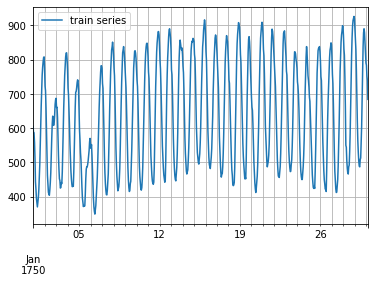

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)

print(train_series.shape)
print(train_series.head())

train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

test-data中包含了 748 - 700 = 48 条数据

(748,)
1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
Freq: H, dtype: float32
train_index[-1] - train数据集的Index的最后一条是:1750-01-30 03:00:00


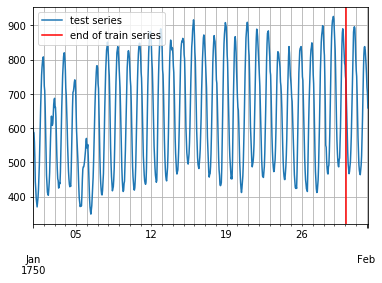

In [10]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()

print(test_series.shape)
print(test_series.head())
print('train_series.index[-1] - train数据集的Index的最后一条是:{}'.format(train_series.index[-1]))
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

* 测试数据集中包含了48个数据，数据频率是小时H,推荐的预测长度是48,也就是dataset.metadata.prediction_length

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### 2.用户自定义的数据集（Custom datasets）

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Timestamp` (possibly different for each time series):

* GluonTS并不要求特定的格式
* 用户自定义的数据集应该是可以迭代的 iterable,并且有'target'、'start'字段

In [15]:
N = 10  # number of time series 10条
T = 100  # number of timesteps 100个数据步
prediction_length = 24 # 预测长度
freq = "1H" # 频率，1H时1条
custom_dataset = np.random.normal(size=(N, T)) # 构造数据集
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series 起始日期是2019-01-01日

In [16]:
custom_dataset.shape

(10, 100)

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

把数据集转化为GluonTS要求的格式

* 注意，train是10条记录，每条train中，包含了100 - 24 = 76个点，而test中包含了整个数据的长度，也就是100条。


In [28]:
custom_dataset[:, :-prediction_length].shape # 

(10, 76)

In [34]:
[{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]].__len__() # 注意，train是10条记录，每条train中，包含了100 - 24 = 76个点，而test中包含了整个数据的长度，也就是100条。

10

In [18]:
from gluonts.dataset.common import ListDataset

In [19]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start} for x in custom_dataset],
                      freq=freq)

In [23]:
ListDataset?

Init signature: ListDataset(*args, **kwds)
Docstring:     
Dataset backed directly by an list of dictionaries.

data_iter
    Iterable object yielding all items in the dataset.
    Each item should be a dictionary mapping strings to values.
    For instance: {"start": "2014-09-07", "target": [0.1, 0.2]}.
freq
    Frequency of the observation in the time series.
    Must be a valid Pandas frequency.
one_dim_target
    Whether to accept only univariate target time series.
File:           ~/.local/lib/python3.7/site-packages/gluonts/dataset/common.py
Type:           ABCMeta
Subclasses:     


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

* 自带了一些pre-built模型。用户需要的是配置一些超参数。pre-built模型主要研究的是概率预测，而不仅仅是单个样本点的估计
* 这儿展示的是GulonTS的一个简单的前向神经网络
* `SimpleFeedForwardEstimator`的参数：输入是`context_length`， `prediction_length` ，模型是`Estimator`

In [35]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

In [36]:
dataset.metadata.prediction_length

48

In [38]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10], # 隐藏层的节点个数
    prediction_length=dataset.metadata.prediction_length, # 预测步长48
    context_length=100, # 用多少步长的数据来做输入
    freq=dataset.metadata.freq, # 频率
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

* 在estimator中定义好超参数
* 然后输入dataset.train，开始训练，获取拟合好的模型

In [39]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:00<00:00, 124.09it/s, epoch=5/5, avg_epoch_loss=4.85]


With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [41]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [110]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation，因为是用100个样本点来做预测的，所以这儿是100?
)

In [115]:
make_evaluation_predictions?

Signature:
make_evaluation_predictions(
    dataset: Iterable[Dict[str, Any]],
    predictor: gluonts.model.predictor.Predictor,
    num_samples: int,
) -> Tuple[Iterator[gluonts.model.forecast.Forecast], Iterator[pandas.core.series.Series]]
Docstring:
Return predictions on the last portion of predict_length time units of the
target. Such portion is cut before making predictions, such a function can
be used in evaluations where accuracy is evaluated on the last portion of
the target.

Parameters
----------
dataset
    Dataset where the evaluation will happen. Only the portion excluding
    the prediction_length portion is used when making prediction.
predictor
    Model used to draw predictions.
num_samples
    Number of samples to draw on the model when evaluating.

Returns
-------
File:      ~/.local/lib/python3.7/site-packages/gluonts/evaluation/backtest.py
Type:      function


First, we can convert these generators to lists to ease the subsequent computations.

In [111]:
forecast_it, ts_it 

(<generator object GluonPredictor.predict at 0x7f149407cd50>,
 <generator object make_evaluation_predictions.<locals>.ts_iter at 0x7f148baa38d0>)

In [112]:
forecasts = list(forecast_it)
tss = list(ts_it)

#### 理解输出结果
We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

`tss[0]`就是原始值

In [99]:
test_series.head(5)

1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
Freq: H, dtype: float32

In [116]:
test_series.shape

(748,)

In [102]:
tss[0].head()

,0
1750-01-01 00:00:00,605.0
1750-01-01 01:00:00,586.0
1750-01-01 02:00:00,586.0
1750-01-01 03:00:00,559.0
1750-01-01 04:00:00,511.0


In [103]:
tss[0].shape

(748, 1)

In [100]:
test_series.shape

(748,)

In [80]:
len(tss)

414

In [83]:
len(tss[0]),len(tss[1])  # tss[0]是原始数据，后面的413个是什么呢？

(748, 748)

In [60]:
# first entry of the time series list
ts_entry = tss[0]
ts_entry.shape

(748, 1)

In [61]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [56]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [58]:
dataset_test_entry['target'].shape

(748,)

In [47]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

#### 理解 'forecast'
The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [113]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [114]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


* start_date刚好是test_series的起始日期
* 为什么是 100 ×４８呢,而且这个１００是可以选择的，比如可以设定为73等等？

In [104]:
test_series.tail(48)


1750-01-30 04:00:00    619.0
1750-01-30 05:00:00    565.0
1750-01-30 06:00:00    532.0
1750-01-30 07:00:00    495.0
1750-01-30 08:00:00    481.0
1750-01-30 09:00:00    467.0
1750-01-30 10:00:00    473.0
1750-01-30 11:00:00    488.0
1750-01-30 12:00:00    501.0
1750-01-30 13:00:00    534.0
1750-01-30 14:00:00    576.0
1750-01-30 15:00:00    639.0
1750-01-30 16:00:00    712.0
1750-01-30 17:00:00    772.0
1750-01-30 18:00:00    830.0
1750-01-30 19:00:00    880.0
1750-01-30 20:00:00    893.0
1750-01-30 21:00:00    896.0
1750-01-30 22:00:00    891.0
1750-01-30 23:00:00    854.0
1750-01-31 00:00:00    803.0
1750-01-31 01:00:00    769.0
1750-01-31 02:00:00    751.0
1750-01-31 03:00:00    701.0
1750-01-31 04:00:00    635.0
1750-01-31 05:00:00    572.0
1750-01-31 06:00:00    532.0
1750-01-31 07:00:00    493.0
1750-01-31 08:00:00    477.0
1750-01-31 09:00:00    468.0
1750-01-31 10:00:00    464.0
1750-01-31 11:00:00    477.0
1750-01-31 12:00:00    492.0
1750-01-31 13:00:00    519.0
1750-01-31 14:

We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [88]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [601.14185 580.353   485.6202  512.56696 522.21936 517.83185 503.95383
 481.90616 547.03204 549.44745 635.0032  701.1394  708.81116 766.2428
 866.4239  880.1465  883.7874  874.1189  867.7092  901.4093  874.9715
 765.1121  750.79065 691.91486 652.1287  653.67114 535.9826  480.6311
 430.1147  508.55646 510.15668 511.077   504.9245  561.51624 650.0287
 671.73724 837.78674 712.37286 824.56146 827.58813 834.74835 902.92303
 932.95795 867.9084  888.73517 824.91693 712.2837  748.7484 ]
0.5-quantile (median) of the future window:
 [607.09784 576.655   506.88394 515.0749  520.4905  518.0205  518.8698
 497.74368 548.5247  535.43085 632.523   699.83923 728.30707 778.6299
 865.5506  881.17456 890.6338  881.9957  868.22656 902.6605  884.31696
 757.14575 743.64636 683.5246  655.2924  644.31683 534.12524 488.7298
 436.8751  519.4302  504.62512 503.91608 502.55344 558.35565 639.0389
 663.3208  820.4615  697.7351  830.13513 843.21344 821.1495  900.90247
 929.7094  836.79614 

In [91]:
len(forecast_entry.mean),len(forecast_entry.quantile(0.5))

(48, 48)

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [72]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='r')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

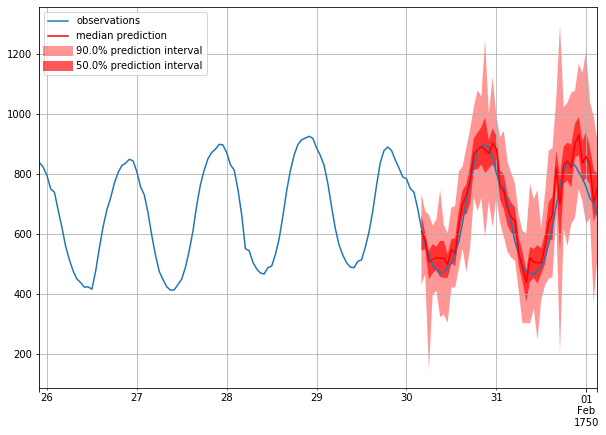

In [73]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [26]:
from gluonts.evaluation import Evaluator

In [27]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation:   0%|          | 0/414 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 3241.66it/s]

Aggregate metrics aggregate both across time-steps and across time series.

In [28]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 12101631.625369696,
    "abs_error": 10782572.400714874,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.439704231422465,
    "MAPE": 0.25551821431344396,
    "sMAPE": 0.20472648772368285,
    "OWA": NaN,
    "MSIS": 41.045364460707596,
    "QuantileLoss[0.1]": 6404319.319882775,
    "Coverage[0.1]": 0.07789855072463768,
    "QuantileLoss[0.5]": 10782572.489516258,
    "Coverage[0.5]": 0.4493760064412239,
    "QuantileLoss[0.9]": 7588274.864356994,
    "Coverage[0.9]": 0.8805354267310788,
    "RMSE": 3478.739947936565,
    "NRMSE": 0.4749248416472312,
    "ND": 0.07407705813350283,
    "wQuantileLoss[0.1]": 0.043998140418980036,
    "wQuantileLoss[0.5]": 0.07407705874357481,
    "wQuantileLoss[0.9]": 0.05213200128595506,
    "mean_wQuantileLoss": 0.056735733482836635,
    "MAE_Coverage": 0.030730005367686566
}


Individual metrics are aggregated only across time-steps.

In [29]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,3994.760742,2429.338379,31644.0,659.250000,42.371302,1.194469,0.079301,0.078569,NaN,7.073095,1291.332751,0.000000,2429.338623,0.583333,1585.751196,1.000000
1,1.0,160574.177083,16493.531250,124149.0,2586.437500,165.107988,2.081155,0.132854,0.122264,NaN,10.772785,4394.538159,0.083333,16493.532104,0.854167,8981.440332,1.000000
2,2.0,40678.536458,7389.302246,65030.0,1354.791667,78.889053,1.951396,0.106714,0.115046,NaN,11.126965,4116.862769,0.000000,7389.302246,0.187500,2021.011438,0.854167
3,3.0,209370.916667,17543.216797,235783.0,4912.145833,258.982249,1.411231,0.074940,0.076595,NaN,7.967328,11107.517554,0.000000,17543.217041,0.375000,8701.089697,1.000000
4,4.0,122662.833333,14072.590820,131088.0,2731.000000,200.494083,1.462282,0.108251,0.105325,NaN,8.038041,5843.049829,0.041667,14072.590942,0.625000,8156.779077,0.979167


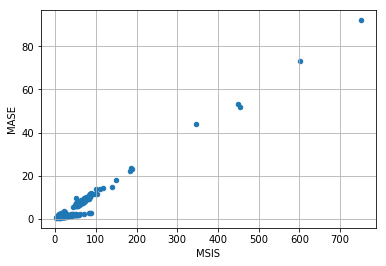

In [30]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## Create your own forecast model

For creating your own forecast model you need to:

- Define the training and prediction network
- Define a new estimator that specifies any data processing and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:

- Both should have a `hybrid_forward` method that defines what should happen when the network is called    
- The training network's `hybrid_forward` should return a **loss** based on the prediction and the true values
- The prediction network's `hybrid_forward` should return the predictions 

For example, we can create a simple training network that defines a neural network which takes as an input the past values of the time series and outputs a future predicted window of length `prediction_length`. It uses the L1 loss in the `hybrid_forward` method to evaluate the error among the predictions and the true values of the time series. The corresponding prediction network should be identical to the training network in terms of architecture (we achieve this by inheriting the training network class), and its `hybrid_forward` method outputs directly the predictions.

Note that this simple model does only point forecasts by construction, i.e., we train it to outputs directly the future values of the time series and not any probabilistic view of the future (to achieve this we should train a network to learn a probability distribution and then sample from it to create sample paths).

In [31]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

Now, we need to construct the estimator which should also follow some rules:

- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object

A `Predictor` defines the `predict` method of a given predictor. Roughly, this method takes the test dataset, it passes it through the prediction network and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method.

Earlier, we used the `make_evaluation_predictions` to evaluate our predictor. Internally, the `make_evaluation_predictions` function invokes the `predict` method of the predictor to get the forecasts.

In [32]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from gluonts.dataset.field_names import FieldName
from mxnet.gluon import HybridBlock

In [33]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq


    def create_transformation(self):
        # Feature transformation that the model uses for input.
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

Now, we can repeat the same pipeline as in the case we had a pre-built model: train the predictor, create the forecasts and evaluate the results.

In [34]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

In [35]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 159.53it/s, epoch=1/5, avg_epoch_loss=3.94e+3]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 160.95it/s, epoch=2/5, avg_epoch_loss=1.53e+3]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 161.80it/s, epoch=3/5, avg_epoch_loss=1.15e+3]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 159.41it/s, epoch=4/5, avg_epoch_loss=1.21e+3]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 160.17it/s, epoch=5/5, avg_epoch_loss=1.32e+3]

In [36]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
    num_samples=100
)

In [37]:
forecasts = list(forecast_it)
tss = list(ts_it)

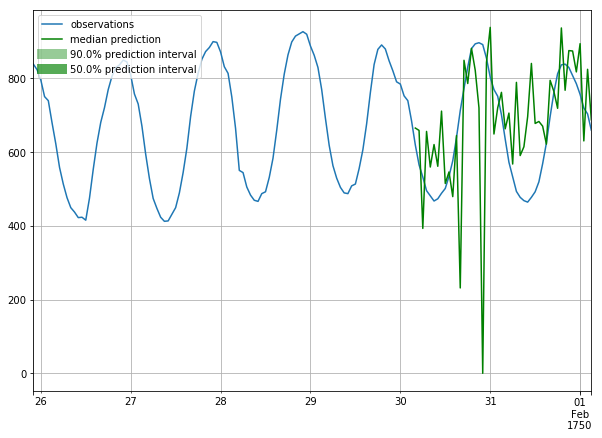

In [38]:
plot_prob_forecasts(tss[0], forecasts[0])

Observe that we cannot actually see any prediction intervals in the predictions. This is expected since the model that we defined does not do probabilistic forecasting but it just gives point estimates. By requiring 100 sample paths (defined in `make_evaluation_predictions`) in such a network, we get 100 times the same output.

In [39]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation:   0%|          | 0/414 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 4301.81it/s]

In [40]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 131805789.34189379,
    "abs_error": 28662775.770095825,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 14.24122799816018,
    "MAPE": 0.7385227455509904,
    "sMAPE": 0.3578597847647227,
    "OWA": NaN,
    "MSIS": 569.649123033223,
    "QuantileLoss[0.1]": 34865029.33298111,
    "Coverage[0.1]": 0.6428140096618358,
    "QuantileLoss[0.5]": 28662775.728061676,
    "Coverage[0.5]": 0.6428140096618358,
    "QuantileLoss[0.9]": 22460522.12314224,
    "Coverage[0.9]": 0.6428140096618358,
    "RMSE": 11480.670247938218,
    "NRMSE": 1.567365075029622,
    "ND": 0.19691535823568182,
    "wQuantileLoss[0.1]": 0.23952529217928487,
    "wQuantileLoss[0.5]": 0.19691535794690415,
    "wQuantileLoss[0.9]": 0.15430542371452338,
    "mean_wQuantileLoss": 0.19691535794690415,
    "MAE_Coverage": 0.3142713365539453
}


In [41]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,3.625933e+04,5893.647461,31644.0,659.250000,42.371302,2.897818,0.198895,0.209442,NaN,115.912725,6895.284088,0.708333,5893.647491,0.708333,4892.010895,0.708333
1,1.0,8.364015e+05,34106.570312,124149.0,2586.437500,165.107988,4.303569,0.314499,0.287493,NaN,172.142735,51620.575244,0.812500,34106.569580,0.812500,16592.563916,0.812500
2,2.0,1.609220e+05,14007.488281,65030.0,1354.791667,78.889053,3.699153,0.222345,0.247435,NaN,147.966109,10007.597290,0.458333,14007.487427,0.458333,18007.377563,0.458333
3,3.0,1.716085e+06,43690.757812,235783.0,4912.145833,258.982249,3.514620,0.195965,0.208359,NaN,140.584794,49756.840283,0.666667,43690.760010,0.666667,37624.679736,0.666667
4,4.0,6.960100e+05,29052.732422,131088.0,2731.000000,200.494083,3.018868,0.244271,0.251765,NaN,120.754733,32821.401831,0.666667,29052.731812,0.666667,25284.061792,0.666667
5,5.0,2.719242e+06,55164.761719,303379.0,6320.395833,212.875740,5.398764,0.183016,0.203394,NaN,215.950561,62993.584375,0.708333,55164.761719,0.708333,47335.939063,0.708333
6,6.0,1.170664e+08,350763.437500,1985325.0,41360.937500,1947.687870,3.751921,0.187012,0.204808,NaN,150.076847,359107.347656,0.604167,350763.425781,0.604167,342419.503906,0.604167
7,7.0,7.644396e+07,271783.343750,1540706.0,32098.041667,1624.044379,3.486452,0.181132,0.201930,NaN,139.458063,269949.071094,0.604167,271783.324219,0.604167,273617.577344,0.604167
8,8.0,9.655072e+07,343802.093750,1640860.0,34184.583333,1850.988166,3.869578,0.221427,0.226824,NaN,154.783134,472858.599219,0.812500,343802.089844,0.812500,214745.580469,0.812500
9,9.0,1.095674e+04,3286.791016,21408.0,446.000000,10.526627,6.504915,0.157079,0.177393,NaN,260.196591,3577.540485,0.541667,3286.791046,0.541667,2996.041608,0.541667


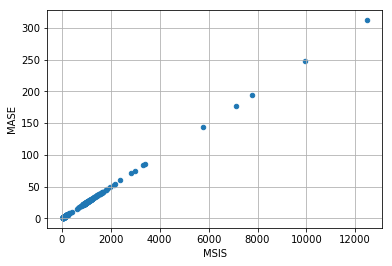

In [42]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()